<a href="https://colab.research.google.com/github/Anderche/content-based-recommendation-system/blob/main/Anders%20Kiss_Content_Based_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content-Based Recommendation Systems

Anders Kiss

---

##Business understanding

Recommend an AirBnb listing based on the description of a User's historical listing.

The following implementation compares recommendation accuracy scores of two algorithms, BERT and TF-IDF

---


### Visual Representation


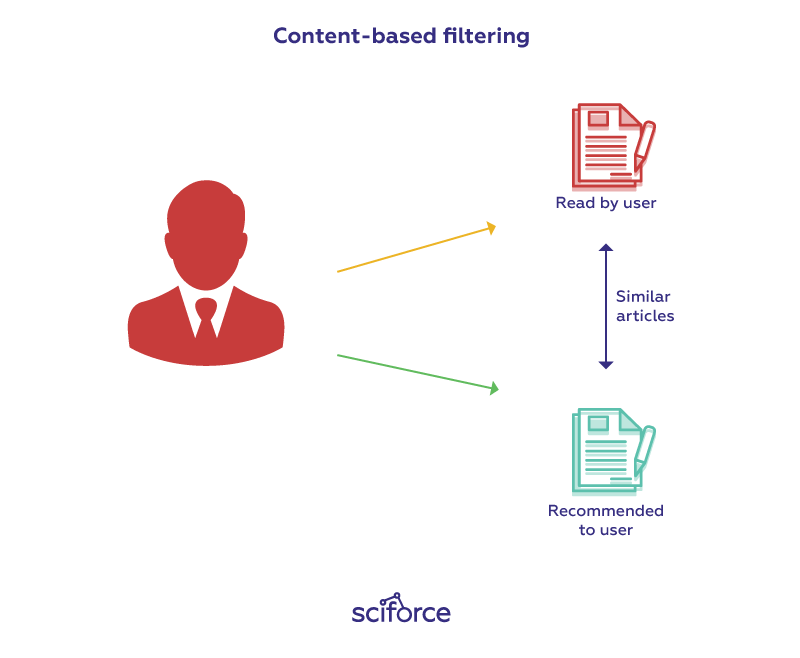

---


### References

Data Source

* https://www.kaggle.com/code/rdaldian/airbnb-content-based-recommendation-system/data

Sources of Information

* https://towardsdatascience.com/hands-on-content-based-recommender-system-using-python-1d643bf314e4
* https://iopscience.iop.org/article/10.1088/1742-6596/1485/1/012017/pdf
* https://www.kaggle.com/code/rdaldian/airbnb-content-based-recommendation-system/notebook


## Step 1 - Install Dependencies / Imports

### Installing dependencies

SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. Before importing the library, we first need to install the Sentence Transformers library. 

**NOTE**: If any other libraries are not installed locally, run the command:

```!pip install name_of_library```



In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 4.0 MB 35.2 MB/s 
     |████████████████████████████████| 1.2 MB 47.2 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 6.6 MB 38.9 MB/s 
     |████████████████████████████████| 596 kB 59.0 MB/s 
     |████████████████████████████████| 895 kB 58.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=ef80c8accf855ac1779169757e0384501d98fd8d828cb3a14b9a89f8a3db582a
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Importing required libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import linear_kernel
import requests

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 2

### Download and load dataset - in .csv file format - into a Pandas dataframe 

- Navigate to the data source on Kaggle:

  - https://www.kaggle.com/code/rdaldian/airbnb-content-based-recommendation-system/data?select=listings.csv


- There are three files, however, we will only utilize the file listings.csv file. Click the download icon, and save the .csv locally.

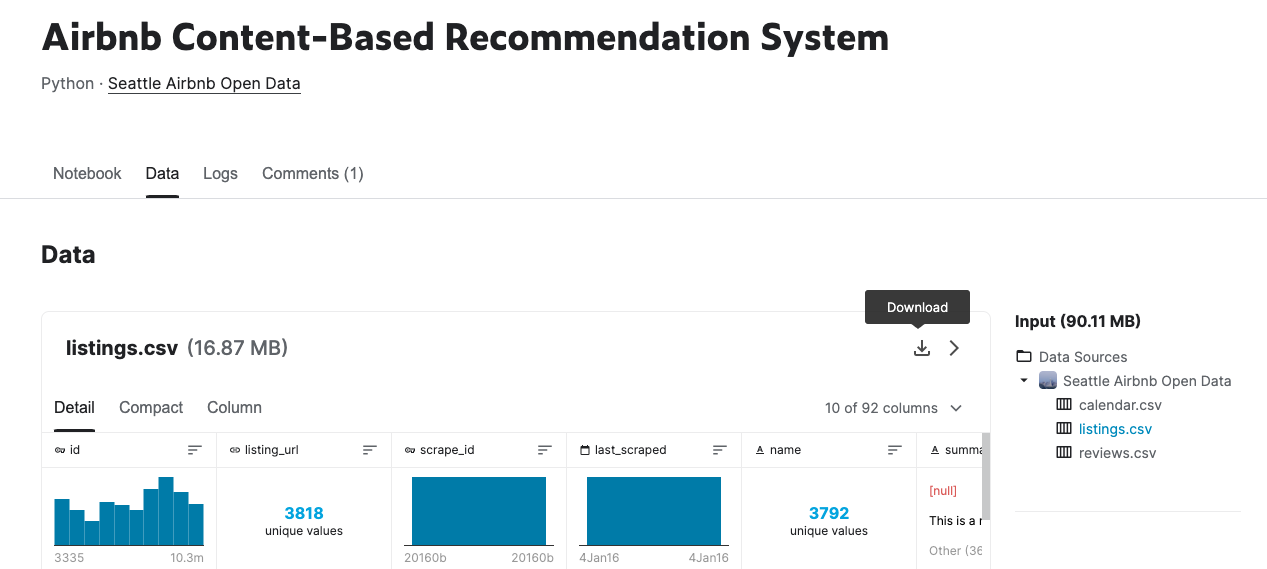


In [ ]:
# MAKE SURE TO PLACE FILE WITHIN GOOGLE DRIVE LOCATION
file_loc = '/content/listings.csv'
data = pd.read_csv(file_loc, usecols = ['id', 'name', 'description'])
X = np.array(data.description)
data.columns

Index(['id', 'name', 'description'], dtype='object')

In [ ]:
data.head()

,id,name,description
0,241032,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...


**Drop** NAN's from the dataset for simplicity 

In [ ]:
data = data.dropna()

In [ ]:
data['content'] = data[['name', 'description']].astype(str).apply(lambda x: ' // '.join(x), axis = 1)

In [ ]:
data.head()

,id,name,description,content
0,241032,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...,Stylish Queen Anne Apartment // Make your self...
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,Bright & Airy Queen Anne Apartment // Chemical...
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,New Modern House-Amazing water view // New mod...
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,Queen Anne Chateau // A charming apartment tha...
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Charming craftsman 3 bdm house // Cozy family ...


In [ ]:
data.shape

(3818, 4)

## Step 3

### TF-IDF

In [ ]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english')
tfidf_matrix = tf.fit_transform(data['content'])

### Transformer

We used **Bidirectional Encoder Representations from Transformers (BERT)** to convert our text into a vector

In [ ]:
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
embed_data = embeddings

In [ ]:
X = np.array(embed_data)
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()

In [ ]:
sns.pairplot(pca_data)

### Cosine Similarity
Cosine Similarity calculates similarity by measuring the cosine angle between two vectors. Vectors are converted from contents by TF-IDF and this measurement will identify which contents are closest to each other.

In [ ]:
cosine_sim_Bert = pd.DataFrame(cosine_similarity(X))
cosine_sim_TFidf = pd.DataFrame(linear_kernel(tfidf_matrix, tfidf_matrix))

## Step 4

###Making Prediction 

In [ ]:
def give_recommendations(index,print_recommendation = False,print_recommendation_plots= False, model=None):
  index_recomm =model.loc[index].sort_values(ascending=False).index.tolist()[1:6]
  air_recomm =  data['name'].loc[index_recomm].values
  result = {'AirBnb_Hotel':air_recomm,'Index':index_recomm}
  if print_recommendation==True:
    print('The stayed hotel is this one: %s \n'%(data['name'].loc[index]))
    k=1
    for hotel in air_recomm:
      print('The number %i recommended hotel is this one: %s \n'%(k,hotel))
  if print_recommendation_plots==True:
    print('The description of the Stayed Hotel is this one:\n %s \n'%(data['description'].loc[index]))
    k=1
    for q in range(len(air_recomm)):
      plot_q = data['description'].loc[index_recomm[q]]
      print('The Description of the number %i recommended Hotel is this one:\n %s \n'%(k,plot_q))
      k=k+1
  return result

In [ ]:
def ploting(model=None):
  plt.figure(figsize=(20,20))
  for q in range(1,5):
    plt.subplot(2,2,q)
    index = np.random.choice(np.arange(0,len(X)))
    to_plot_data = model.drop(index,axis=1)
    plt.plot(to_plot_data.loc[index],'.',color='firebrick')
    recomm_index = give_recommendations(index,model=model)
    #print(recomm_index)
    x = recomm_index['Index']
    y = model.loc[index][x].tolist()
    m = recomm_index['AirBnb_Hotel']
    plt.plot(x,y,'.',color='navy',label='Recommended Hotel')
    plt.title('Hotel Stayed: '+data['name'].loc[index])
    plt.xlabel('Hotel Index')
    k=0
    for x_i in x:
      plt.annotate('%s'%(m[k]),(x_i,y[k]),fontsize=10)
      k=k+1

    plt.ylabel('Cosine Similarity')
    plt.ylim(0,1)

In [ ]:
give_recommendations(2,True,model=cosine_sim_Bert)

In [ ]:
give_recommendations(2,False,True,model=cosine_sim_Bert)

In [ ]:
give_recommendations(10,True,True,model=cosine_sim_Bert)

## Step 5 - Results


Bert recommendation 

In [ ]:
recomm_list = []
for i in range(len(X)):
  recomm_i = give_recommendations(i, model=cosine_sim_Bert)
  recomm_list.append(recomm_i['AirBnb_Hotel'])
recomm_data = pd.DataFrame(recomm_list,columns=['First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation'])
recomm_data['Stayed Hotel'] = data['name']
recomm_data = recomm_data[['Stayed Hotel','First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation']]

In [ ]:
recomm_data.sample(frac=1).head()

In [ ]:
ploting(model=cosine_sim_Bert)

TF-IDF recommendation 

In [ ]:
recomm_list_tf = []
for i in range(len(data['content'])):
  recomm_i = give_recommendations(i, model=cosine_sim_TFidf)
  recomm_list_tf.append(recomm_i['AirBnb_Hotel'])
recomm_data_tf = pd.DataFrame(recomm_list,columns=['First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation'])
recomm_data_tf['Stayed Hotel'] = data['name']
recomm_data_tf = recomm_data_tf[['Stayed Hotel','First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation']]

In [ ]:
recomm_data_tf.sample(frac=1).head()

In [ ]:
ploting(model=cosine_sim_TFidf)

### Conclusion 

The Recommendation from BERT and TF-IDF are shared above.

There are many ways to get a recommender system. 

Our assumption is that we are recommending a listing that is similar to somewhere to where a User has already stayed.

We are only considering one listing and the listing attributes (name, description, and content).

From our models BERT performed best.
